# Cеминар №9. Стэкинг

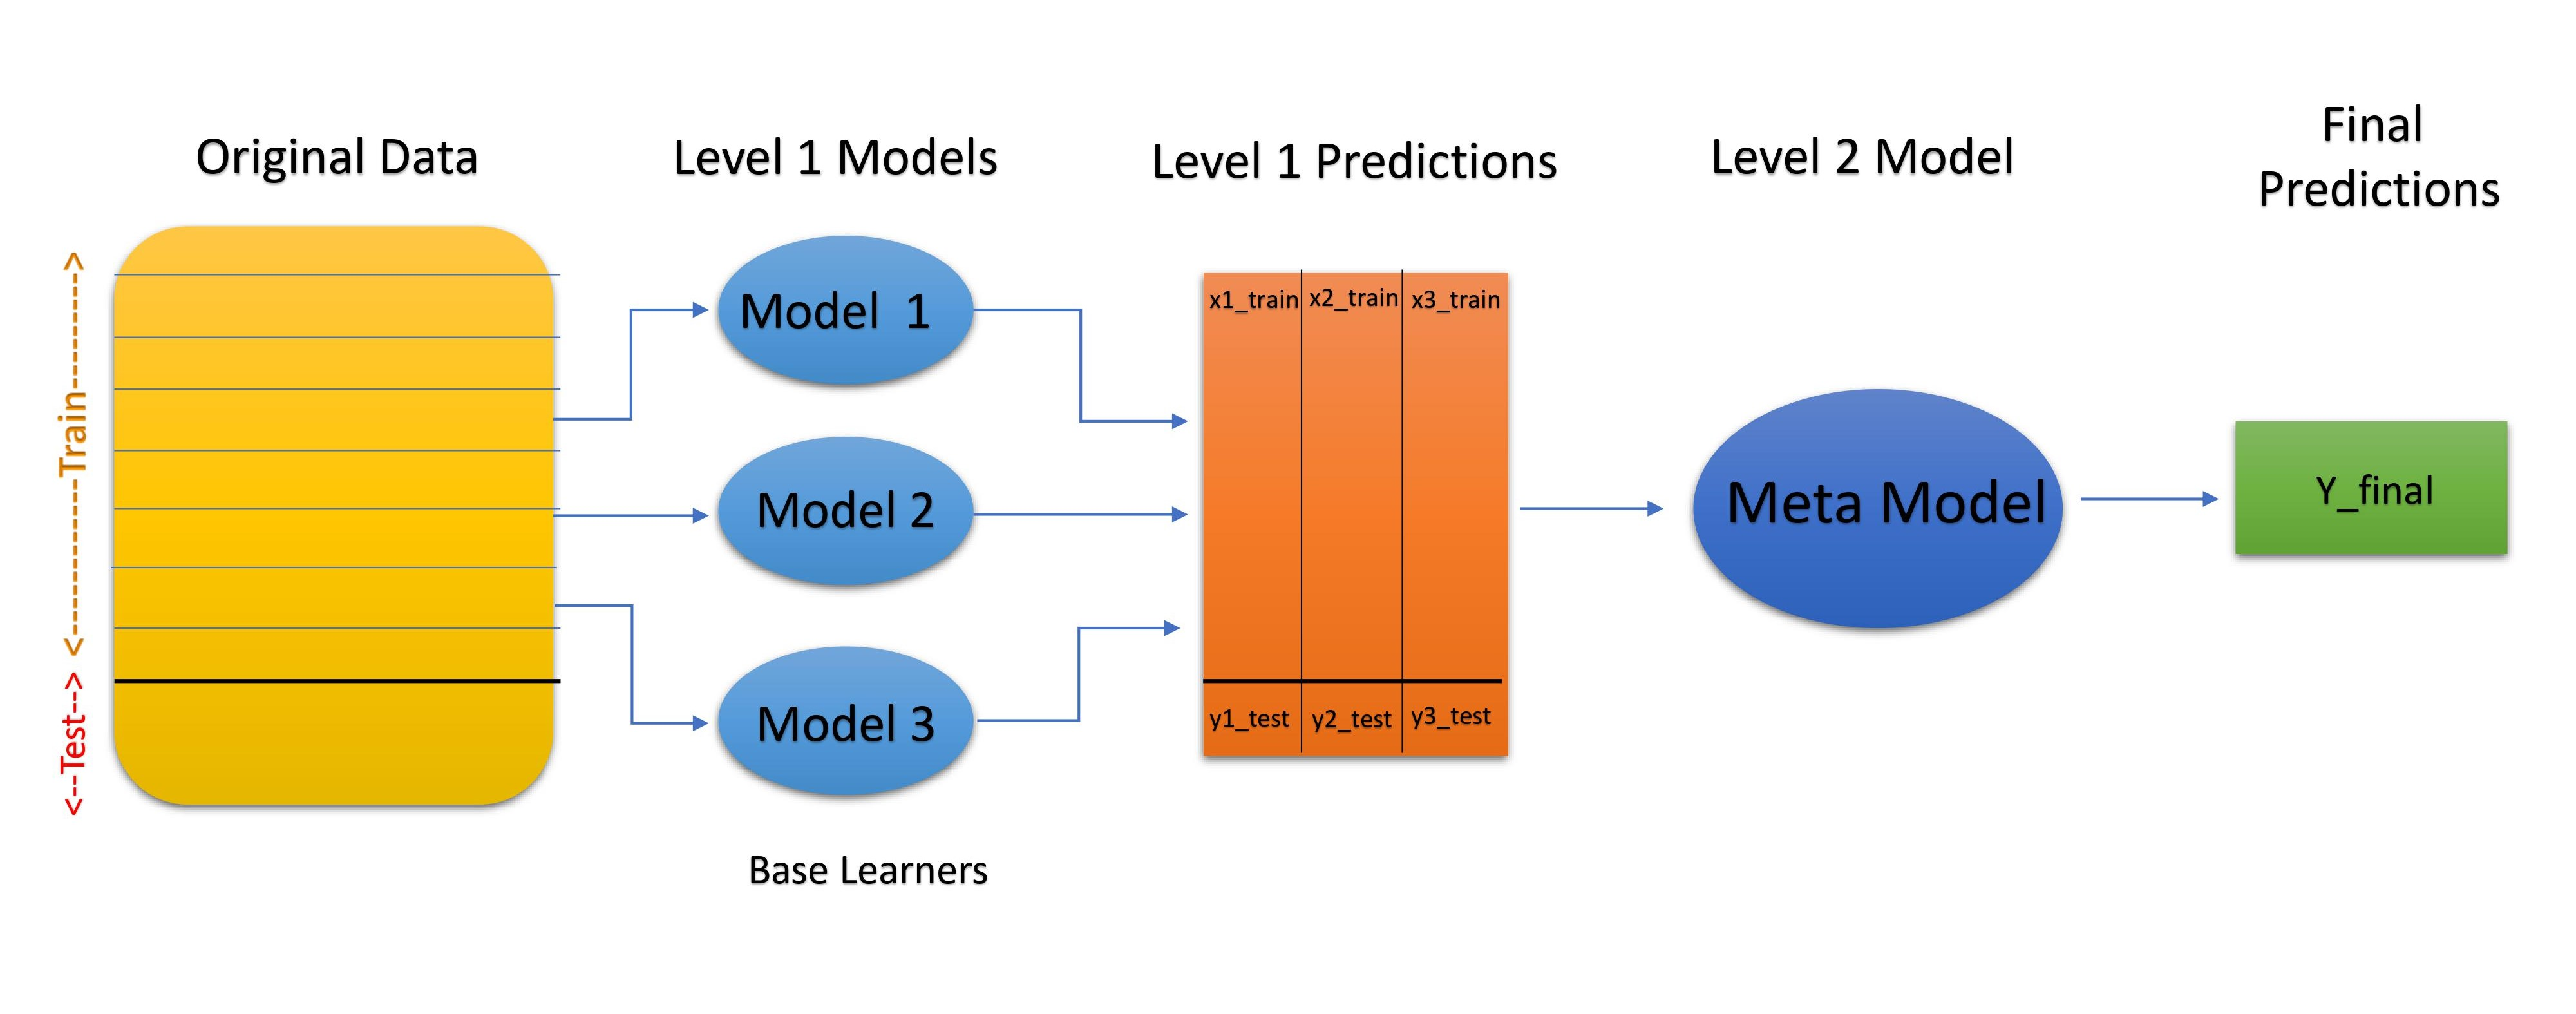

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [2]:
data = pd.read_csv("house_price_regression_dataset.csv")
data

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06
...,...,...,...,...,...,...,...,...
995,3261,4,1,1978,2.165110,2,10,7.014940e+05
996,3179,1,2,1999,2.977123,1,10,6.837232e+05
997,2606,4,2,1962,4.055067,0,2,5.720240e+05
998,4723,5,2,1950,1.930921,0,7,9.648653e+05


In [3]:
X = data.drop(columns=["House_Price"])
y = data["House_Price"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)
y_train = y_train.reset_index()["House_Price"]
y_test = y_test.reset_index()["House_Price"]

In [5]:
model = XGBRegressor(n_estimators=100, max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

10732.28666482125

In [6]:
model = StackingRegressor(
    [
        ("tree", DecisionTreeRegressor(max_depth=10)),
        ("linreg", LinearRegression()),
        ("xgb", XGBRegressor(n_estimators=100, max_depth=3)),
    ],
    final_estimator=LinearRegression(),
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

7086.077056926055

## Blending
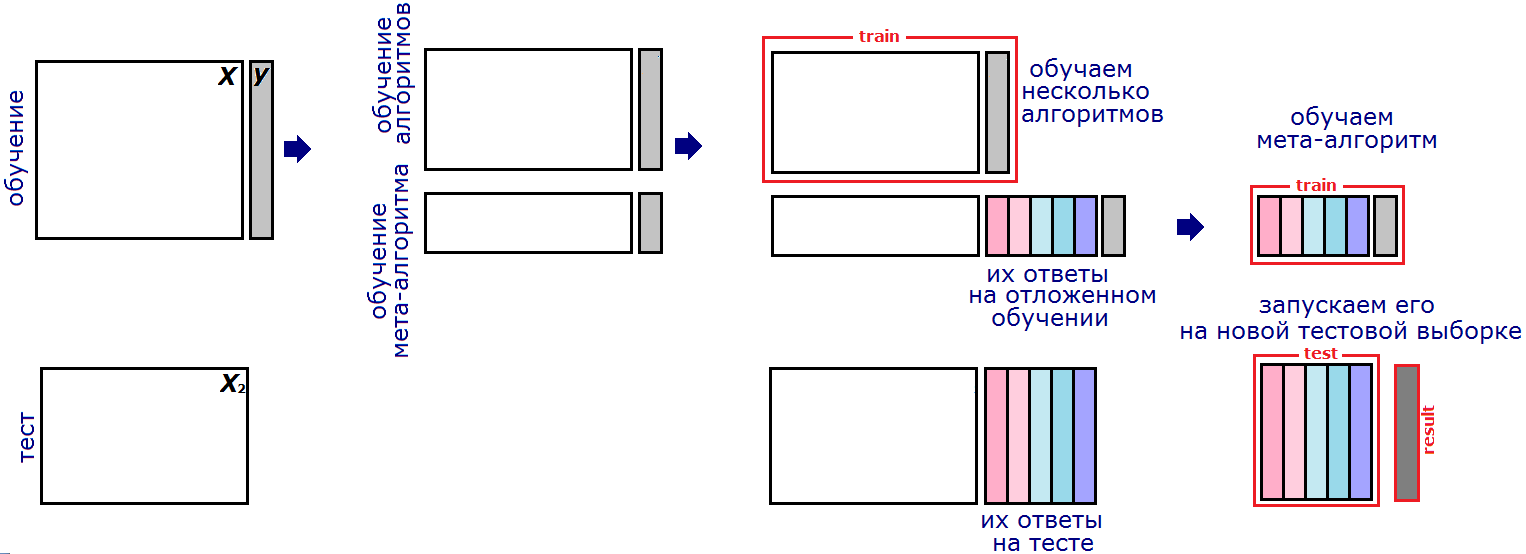

## Стэкинг
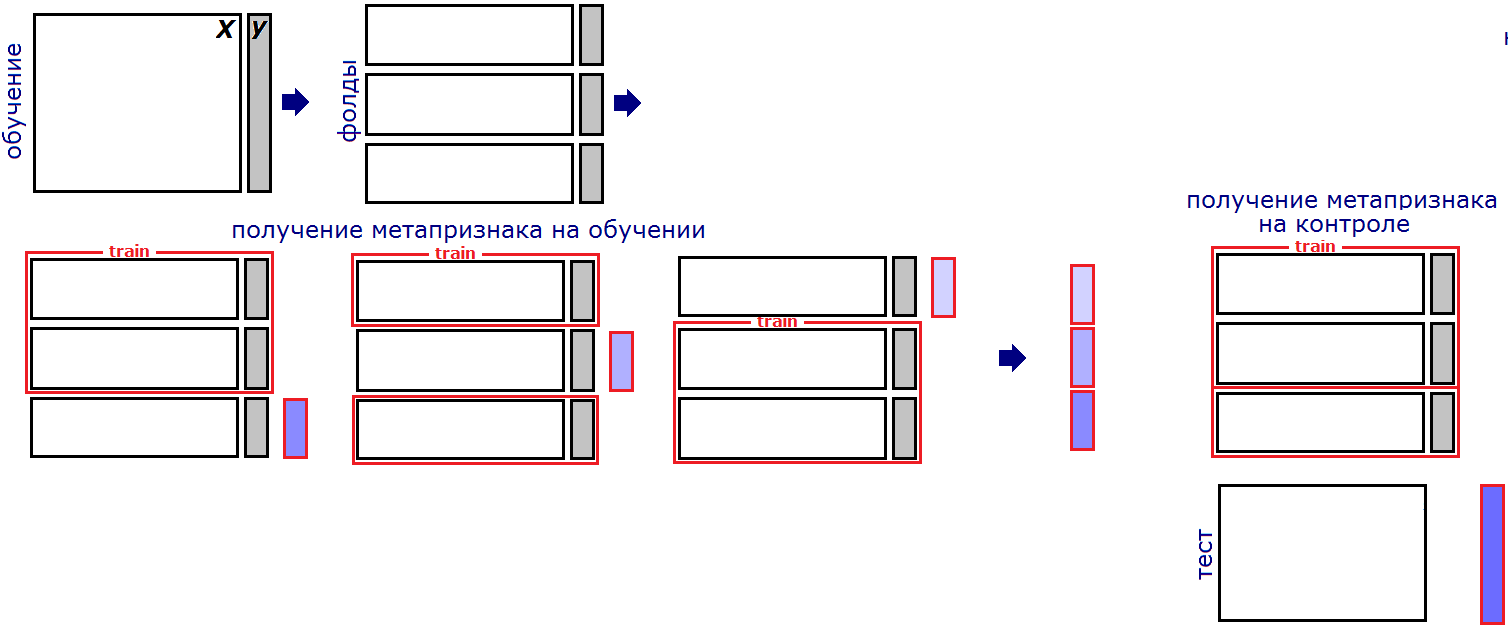

In [7]:
class Stacking:
    def __init__(self, estimators, meta_estimator, folds=5):
        self.estimators = estimators
        self.meta_estimator = meta_estimator
        self.folds = folds
        self.meta_train = []

    def _fit_estimator(self, estimator, X_train, y_train):
        kf = KFold(n_splits=self.folds, shuffle=True)
        train_fold_indices = []
        test_fold_indices = []
        test_fold_predicts = []

        for train_idx, test_idx in kf.split(X_train):
            train_fold_indices.extend(train_idx)
            test_fold_indices.extend(test_idx)

            estimator.fit(X_train[train_idx], y_train[train_idx])
            test_fold_predicts.extend(estimator.predict(X_train[test_idx]))

        estimator.fit(X_train, y_train)
        self.meta_train.append(np.array(test_fold_predicts)[np.argsort(test_fold_indices)])

    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        self.meta_train = []

        for estimator in self.estimators:
            self._fit_estimator(estimator, X_train, y_train)

        self.meta_train = np.array(self.meta_train).transpose()
        self.meta_estimator.fit(self.meta_train, y_train)

    def predict(self, X_test):
        X_test = np.array(X_test)
        meta_features = np.array([estimator.predict(X_test) for estimator in self.estimators]).transpose()
        return self.meta_estimator.predict(meta_features)

In [8]:
model = Stacking(
    estimators=[
        LinearRegression(),
        DecisionTreeRegressor(max_depth=3),
        XGBRegressor(n_estimators=100, max_depth=3),
    ],
    meta_estimator=LinearRegression(),
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

7065.394205298305